<a href="https://colab.research.google.com/github/jaicdev/Notebooks/blob/main/autoencoders_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch for image reconstruction from the Fashion MNIST dataset. Autoencoders are neural networks used in unsupervised learning, focusing on dimensionality reduction and data compression. The code pre-processes the dataset, defines the Autoencoder model, trains it, tracks training losses, saves the trained model, and demonstrates image reconstruction. This practical example serves as an entry point for understanding Autoencoders and their applications in deep learning and image processing with PyTorch.

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import random
from PIL import Image
import numpy as np

In [2]:
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])
# Download the MNIST Dataset
train_set = datasets.FashionMNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)

# DataLoader is used to load the dataset for training
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                     batch_size = 32,
                                     shuffle = True)

# for testing
test_set = datasets.FashionMNIST(root = "./data",
                         train = False,
                         download = True,
                         transform = tensor_transform)

test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                     batch_size = 32,
                                     shuffle = True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12746832.71it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202365.85it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3739787.39it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5807497.85it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



torch.Size([32, 1, 28, 28])


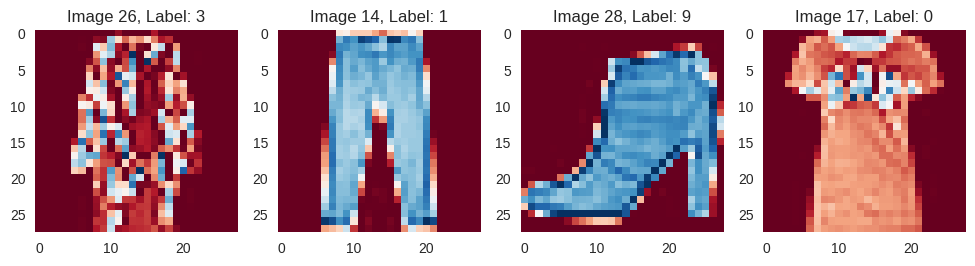

torch.Size([32, 1, 28, 28])


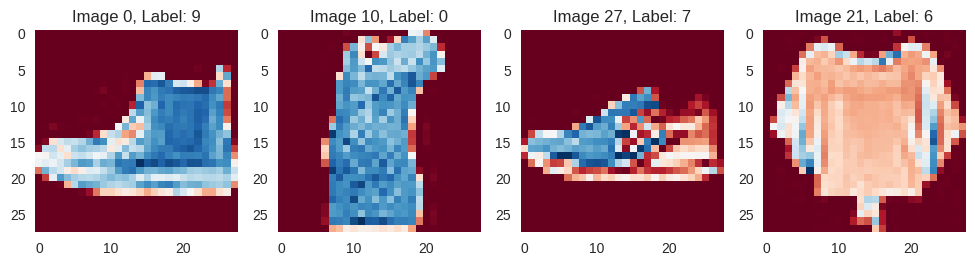

In [10]:
import matplotlib.pyplot as plt
import random

for i, (image, labels) in enumerate(train_loader):
    print(image.shape)
    num_samples = image.shape[0]

    # Generate random indices to select images
    random_indices = [random.randint(0, num_samples - 1) for _ in range(4)]

    # Create subplots to display multiple images
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))

    for j, index in enumerate(random_indices):
        img = image[index]
        img = img.reshape(28, 28)

        # Display each image in a subplot
        axes[j].imshow(img, cmap='RdBu')
        axes[j].set_title(f"Image {index}, Label: {labels[index].item()}")
        axes[j].grid(False)

    plt.show()

    if i >= 1:
        break

Autoencoders are a type of neural network architecture commonly used for unsupervised learning and dimensionality reduction. They consist of two primary components: an encoder and a decoder.

1. **Encoder:** The encoder is the first part of an autoencoder. Its role is to take the input data (in this case, fashion images) and compress it into a lower-dimensional representation, often referred to as a "latent space" or "encoding." The encoder is responsible for capturing the most important and relevant features of the input data. In the context of fashion images, these features could include details like the shape, texture, and style of clothing items. The encoder's architecture typically consists of one or more layers of neural networks that gradually reduce the dimensionality of the input data until it reaches the desired encoding size.

2. **Decoder:** The decoder is the second part of an autoencoder. It takes the lower-dimensional representation generated by the encoder and attempts to reconstruct the original input data from it. The decoder's role is to transform the compressed representation back into a format that closely resembles the original input. In the case of fashion images, this means generating images that look as similar as possible to the original clothing items. The decoder's architecture often mirrors the encoder but in reverse, gradually increasing the dimensionality of the data until it matches the original input's dimensions.

The training process of an autoencoder involves minimizing the reconstruction error, which is the difference between the input data and the data reconstructed by the decoder. By training on a dataset of fashion images, the autoencoder learns to capture and encode the most important features of clothing items in the latent space.

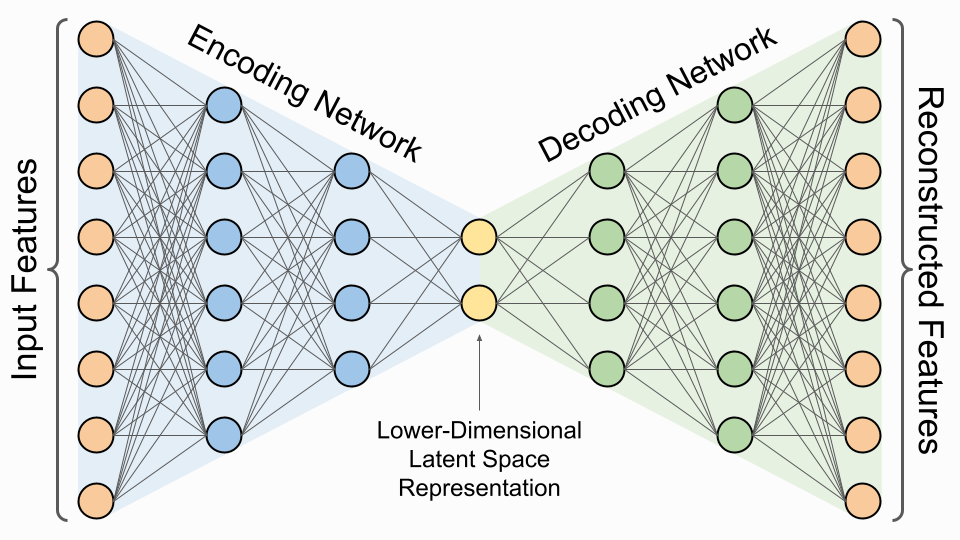

The benefits of using autoencoders for this purpose include:

- **Feature Extraction:** Autoencoders are excellent at automatically learning and extracting meaningful features from data. In the case of fashion images, they can capture details like patterns, shapes, and textures.

- **Dimensionality Reduction:** Autoencoders provide a way to reduce the dimensionality of data while retaining essential information. This can be valuable for various machine learning tasks.

- **Data Reconstruction:** The ability to reconstruct data from the encoded representation is useful for tasks like image denoising or generating similar data samples.

In the context of the provided code, the autoencoder model is trained on a dataset of fashion images to learn how to encode and decode these images effectively. The reconstructed images generated by the decoder should closely resemble the original fashion items, demonstrating the autoencoder's ability to capture and represent essential features from the input data.

In [5]:
# Creating a PyTorch class
class AE(torch.nn.Module):
	def __init__(self):
		super().__init__()

		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(28 * 28, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 32),
			torch.nn.ReLU(),
			torch.nn.Linear(32, 16),
			torch.nn.ReLU(),
			torch.nn.Linear(16, 8)
		)

		# Building an linear decoder with Linear layer followed by Relu activation function
		# The Sigmoid activation function outputs the value between 0 and 1
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(8, 16),
			torch.nn.ReLU(),
			torch.nn.Linear(16, 32),
			torch.nn.ReLU(),
			torch.nn.Linear(32, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 28 * 28),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


In [37]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-8)


Epoch:  001, Loss:  0.0270
Epoch:  002, Loss:  0.0249
Epoch:  003, Loss:  0.0218
Epoch:  004, Loss:  0.0299
Epoch:  005, Loss:  0.0277
Epoch:  006, Loss:  0.0220
Epoch:  007, Loss:  0.0274
Epoch:  008, Loss:  0.0245
Epoch:  009, Loss:  0.0262
Epoch:  010, Loss:  0.0232
Epoch:  011, Loss:  0.0258
Epoch:  012, Loss:  0.0238
Epoch:  013, Loss:  0.0211
Epoch:  014, Loss:  0.0256
Epoch:  015, Loss:  0.0205
Epoch:  016, Loss:  0.0216
Epoch:  017, Loss:  0.0220
Epoch:  018, Loss:  0.0193
Epoch:  019, Loss:  0.0211
Epoch:  020, Loss:  0.0191


<ipython-input-38-33bba69bf8ac>:37: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


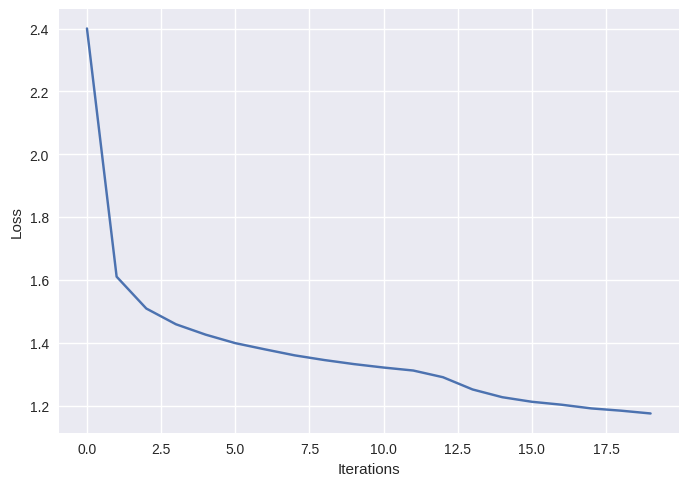

In [38]:
epochs = 20
outputs = []
losses = []

model.train()
for epoch in range(epochs):
	batch_loss = 0.0
	for (image, _) in train_loader:

		# Reshaping the image to (-1, 784)
		image = image.reshape(-1, 28*28)

		# Output of Autoencoder
		reconstructed = model(image)

		# Calculating the loss function
		loss = loss_function(reconstructed, image)

		# The gradients are set to zero,
		# the the gradient is computed and stored.
		# .step() performs parameter update
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		# Storing the losses in a list for plotting
		batch_loss += loss
	avg_loss = batch_loss / 32
	losses.append(avg_loss.item())

	outputs.append((epochs, image, reconstructed))
	print(f"Epoch: {epoch+1: 04d}, Loss: {loss: .4f}")

torch.save(model.state_dict(), 'fashion-mnist_autoenc.pt')

# Defining the Plot Style
plt.style.use('seaborn')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.plot(losses)


In [39]:
model_path = '/content/fashion-mnist_autoenc.pt'

model.load_state_dict(torch.load(model_path))
model.eval()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

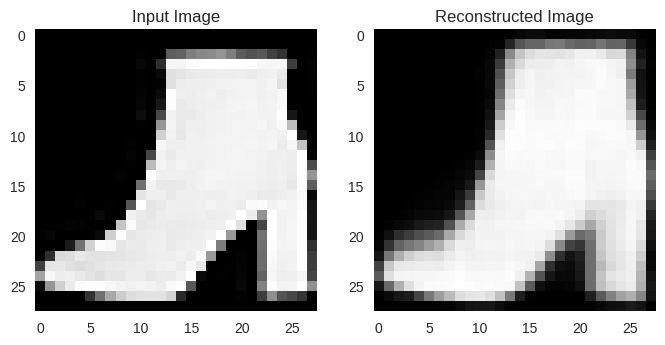

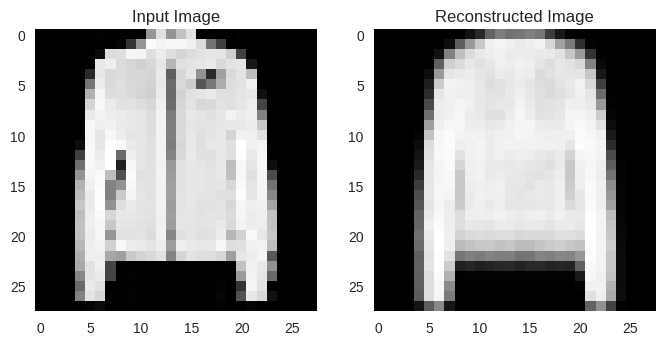

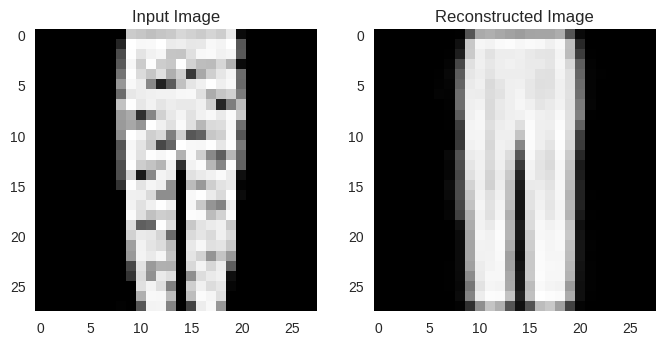

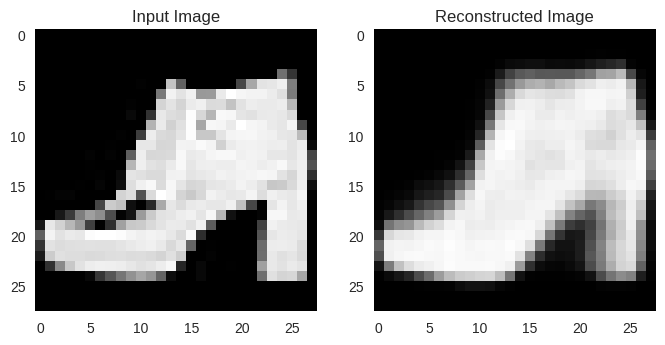

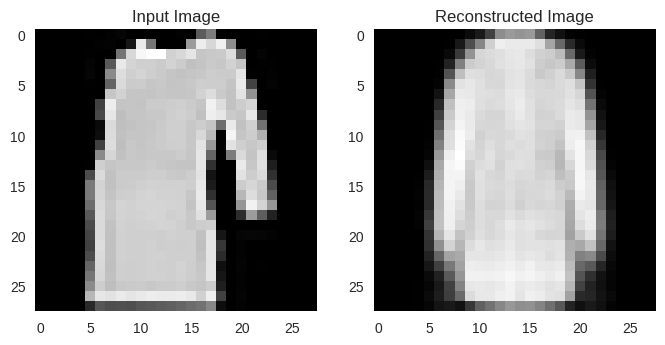

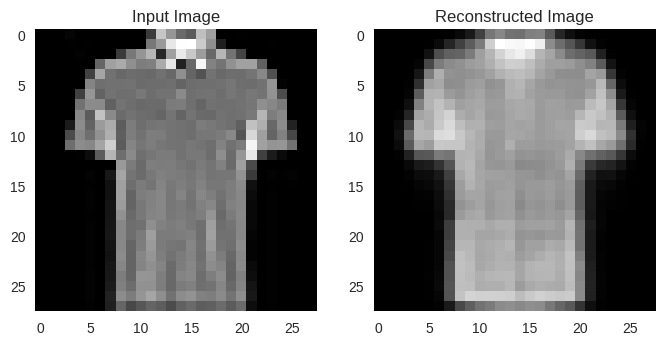

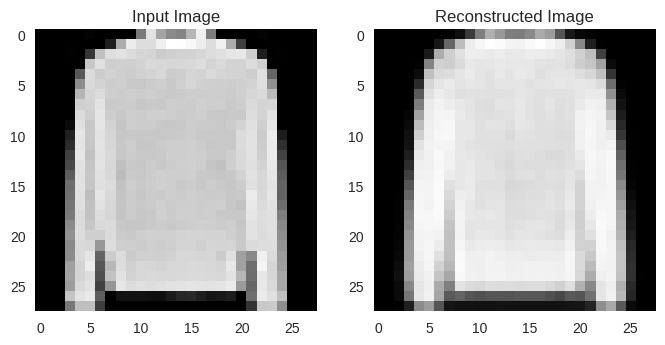

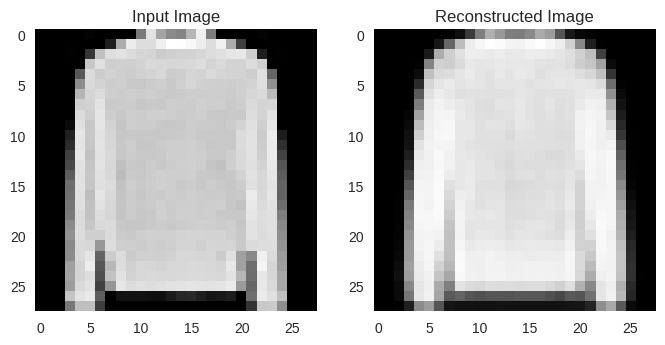

In [40]:
for i, (image, _) in enumerate(test_loader):
    num_samples = image.shape[0]

    # Generate random indices to select images
    random_indices = [random.randint(0, num_samples - 1) for _ in range(4)]

    for index in random_indices:
        target_img = image[index]
        recon = model(target_img.reshape(-1, 28*28))

        # Create a subplot for each pair of images
        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.imshow(1 - target_img.reshape(28, 28))
        ax1.set_title('Input Image')
        ax1.grid(False)

        ax2.imshow(1 - recon.detach().numpy().reshape(28, 28))
        ax2.set_title('Reconstructed Image')
        ax2.grid(False)

    if i >= 1:
        break
plt.show()
